In [1]:
using Pkg
# Pkg.add("CSV")
# Pkg.add("DataFrames")
# Pkg.add("Gurobi")
# Pkg.add("JuMP")
# Pkg.add("LinearAlgebra")
# Pkg.add("Plots")
# Pkg.add("Clustering")
# Pkg.add("StableRNGs")

In [1]:
using CSV, DataFrames, Gurobi, JuMP, LinearAlgebra, Plots, Clustering, StableRNGs, Random, Statistics

In [2]:
function read_data(file, scaling)
    # normalized_root = "./normalized_data"
    # scaled_root = "./scaled_data"
    
    if scaling == "normalized"
        data = CSV.read("./normalized_data/$file", DataFrame)
        for c in names(data, Any)
            data[!, c]= Float64.(data[!, c])
        end
        return data
    elseif scaling == "processed"
        data = CSV.read("./processed_data/$file", DataFrame)
        for c in names(data, Any)
            data[!, c]= Float64.(data[!, c])
        end
        return data
    else
        data = CSV.read("./scaled_data/$file", DataFrame)
        for c in names(data, Any)
            data[!, c]= Float64.(data[!, c])
        end
        return data
    end
end

function k_means_cluster(data, k, seed=0)
    # Documentation: https://clusteringjl.readthedocs.io/en/latest/kmeans.html
    
    data_matrix = Matrix(data)
    kmeans_result = Clustering.kmeans(data_matrix', k; rng=StableRNG(seed))
        # kmeans_result.totalcost (within-cluster sum of square distance)
        # a = assignments(kmeans_result) # get the assignments of points to clusters
        # c = counts(kmeans_result) # get the cluster sizes
        # M = kmeans_result.centers # get the cluster centers
    return kmeans_result
end

k_means_cluster (generic function with 2 methods)

In [47]:
abalone = read_data("abalone_z.csv", "normalized")
similarity_prediction = read_data("similarity_prediction_z.csv", "normalized")

abalone_raw = read_data("abalone.csv", "processed")
similarity_prediction_raw = read_data("similarity_prediction.csv", "processed")

abalone_scaled = read_data("abalone_mm.csv", "scaled")
similarity_prediction_scaled = read_data("similarity_prediction_mm.csv", "scaled")

Row,tanimoto_cdk_Extended,TanimotoCombo,pchembl_distance,target_name_5HT2B,target_name_CYP2D6,target_name_HERG,simil_2D,simil_3D,dissimil_2D,dissimil_3D,pair_type_dis2D_dis3D,pair_type_dis2D_sim3D,pair_type_sim2D_dis3D,pair_type_sim2D_sim3D,n_answers,n_similar,frac_similar
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.472838,1.0,0.0930931,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.578947,0.72,0.818182
2,0.430275,0.866106,0.102102,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.263158,0.36,0.5625
3,0.451161,0.863519,0.147147,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.526316,0.32,0.380952
4,0.463027,0.854463,0.39039,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.473684,0.6,0.75
5,0.333648,0.849935,0.15015,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.631579,0.6,0.652174
6,0.544889,0.849935,0.432432,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.315789,0.28,0.411765
7,0.351486,0.846701,0.027027,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.210526,0.48,0.8
8,0.417813,0.815653,0.0600601,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.947368,0.76,0.655172
9,0.254746,0.796248,0.12012,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.32,0.727273


In [4]:
function k_means_cluster(data, k, seed=0)
    # Documentation: https://clusteringjl.readthedocs.io/en/latest/kmeans.html
    
    data_matrix = Matrix(data)
    kmeans_result = Clustering.kmeans(data_matrix', k; rng=StableRNG(seed))
        # kmeans_result.totalcost (within-cluster sum of square distance)
        # a = assignments(kmeans_result) # get the assignments of points to clusters
        # c = counts(kmeans_result) # get the cluster sizes
        # M = kmeans_result.centers # get the cluster centers
    return kmeans_result
end


function kmeans_optimal(data, num_rows, distance, k_max, time_limit, warm_start = true)

    data = data[1:num_rows, :]
    
    n = size(data)[1]
    p = size(data)[2]
    
    observation_range = 1:n
    variable_range = 1:p
    cluster_range = 1:k_max

    model = Model(optimizer_with_attributes(Gurobi.Optimizer, "TimeLimit" => time_limit))
    
    @variable(model,
        c[k in cluster_range, j in variable_range])
    @variable(model,
        z[i in observation_range, k in cluster_range], Bin)

    @variable(model,
        d[i in observation_range, j in variable_range] >= 0)

    if warm_start == true
        data_kmeans = k_means_cluster(data, k_max)
        for k in cluster_range
            for j in variable_range
                set_start_value(c[k,j], data_kmeans.centers[j,k])
            end
    
            assignments_vector = data_kmeans.assignments  
            for i in observation_range
                set_start_value(z[i,k], assignments_vector[i] == k ? 1 : 0)
            end
        end
    end

    
    @constraint(model,
        ensure_assignment[i in observation_range],
        sum( (z[i, k]) for k in cluster_range) == 1)
    
    @constraint(model,
        cluster_numbers[k in cluster_range],
        sum( (z[i, k]) for i in observation_range) >= 1)

    if distance == "manhattan"
        @constraint(model,
            distance_1[i in observation_range, j in variable_range, k in cluster_range],
            d[i, j] >= data[i, j] - c[k, j] - 1000*(1 - z[i, k]))
        @constraint(model,
            distance_2[i in observation_range, j in variable_range, k in cluster_range],
            d[i, j] >= c[k, j] - data[i, j] - 1000*(1 - z[i, k]))
    else
        @constraint(model,
            distance_1[i in observation_range, j in variable_range, k in cluster_range],
            d[i, j] >= (data[i, j] - c[k, j])^2 - 1000*(1 - z[i, k]))
        @constraint(model,
            distance_2[i in observation_range, j in variable_range, k in cluster_range],
            d[i, j] >= (c[k, j] - data[i, j])^2 - 1000*(1 - z[i, k]))
    end
    
    @objective(model,
        Min,
        sum( sum( (d[i, j]) for j in variable_range) for i in observation_range))
    
    optimize!(model)

    return model
end



function get_assignments(model)
    z_values = value.(model[:z])  
    n, k_max = size(z_values)
    assignments = zeros(Int, n)

    for i in 1:n
        for k in 1:k_max
            if z_values[i, k] > 0.5  
                assignments[i] = k
                break
            end
        end
    end

    return assignments
end

function get_centers(model)
    c_values = value.(model[:c])  
    return c_values
end



function evaluate_clustering(data, assignments, centers, distance)
    data_matrix = Matrix(data)
    K = maximum(assignments)
    n, p = size(data_matrix)

    wcssd = zeros(K)

    for k in 1:K
        cluster_obs = data_matrix[assignments .== k, :]
        for i in 1:size(cluster_obs)[1]
            if distance == "manhattan"
                wcssd[k] += sum(abs.(cluster_obs[i, :] .- centers[k, :]))^2
            else
                wcssd[k] += norm(cluster_obs[i, :] .- centers[k, :])^2
            end
        end
    end

    return sum(wcssd)
end


function average_silhouette_score(data, assignments, centers)
    data_matrix = Matrix(data)
    n = size(data_matrix, 1)
    K = maximum(assignments)

    # Function to compute the average distance to points in a given cluster
    function avg_distance_to_cluster(point, cluster_points)
        return mean([norm(point - other_point) for other_point in eachrow(cluster_points)])
    end

    silhouette_scores = zeros(n)

    for i in 1:n
        # Current point and its assigned cluster
        point = data_matrix[i, :]
        cluster = assignments[i]

        # a(i): Average distance to points in the same cluster
        same_cluster_points = data_matrix[assignments .== cluster, :]
        a_i = cluster == 1 ? 0 : avg_distance_to_cluster(point, same_cluster_points)

        # b(i): Minimum average distance to points in other clusters
        b_i = Inf
        for k in 1:K
            if k != cluster
                other_cluster_points = data_matrix[assignments .== k, :]
                b_i = min(b_i, avg_distance_to_cluster(point, other_cluster_points))
            end
        end

        # Silhouette score for point i
        silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i)
    end

    return mean(silhouette_scores)
end


average_silhouette_score (generic function with 1 method)

# Elbow Method on Data to see Neighborhood of Reasonable k Values

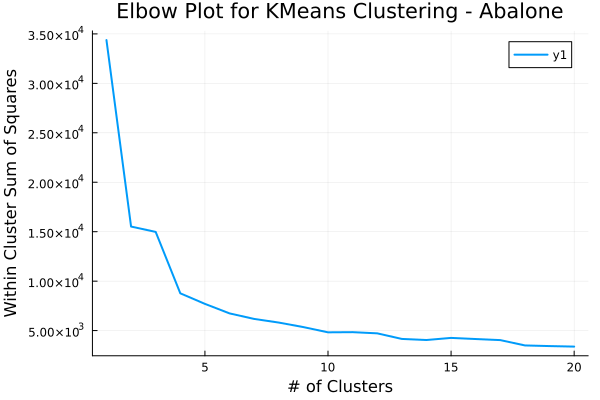

In [54]:
data_matrix = Matrix(abalone)

measure = []
K_max = 20
for k in 1:K_max
    kmeans_result = Clustering.kmeans(data_matrix', k; rng=StableRNG(k+100))
    push!(measure, sum(kmeans_result.totalcost))
end

plot(1:K_max, measure, xlabel="# of Clusters", ylabel="Within Cluster Sum of Squares", title="Elbow Plot for KMeans Clustering - Abalone", linewidth=2)

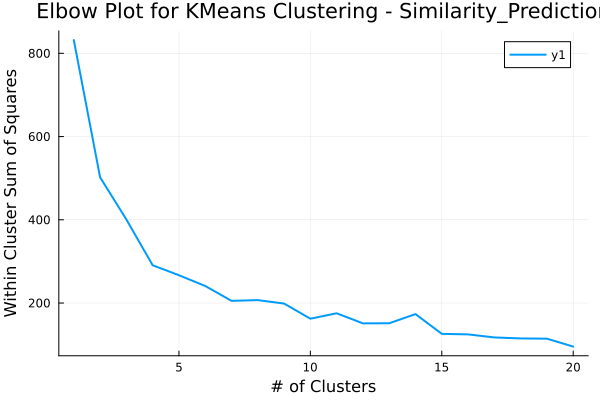

In [55]:
data_matrix = Matrix(similarity_prediction)

measure = []
K_max = 20
for k in 1:K_max
    kmeans_result = Clustering.kmeans(data_matrix', k; rng=StableRNG(k+100))
    push!(measure, sum(kmeans_result.totalcost))
end

plot(1:K_max, measure, xlabel="# of Clusters", ylabel="Within Cluster Sum of Squares", title="Elbow Plot for KMeans Clustering - Similarity_Prediction", linewidth=2)

### Abalone: 3-5 clusters 
### Similarity_Prediction: 3-6 clusters

# Time vs. WCSS - Abalone (manhattan distances)

## Test 1: Small Subset of Abalone Data

In [9]:
# kmeans_optimal(data, num_rows, distance, k_max, time_limit, warm_start)

data = abalone
subset_parameter = 0.25
num_rows = floor(Int, size(abalone)[1] * subset_parameter)
distance = "manhattan"
k_max = 5
times_tested = [30, 60, 90, 120, 180]

models = []
for time_limit in times_tested
    push!(models, kmeans_optimal(data, num_rows, distance, k_max, time_limit))
end

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-20
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 10
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1049 rows, 14661 columns and 10440 nonzeros
Model fingerprint: 0xabeb3380
Model has 93960 quadratic constraints
Variable types: 9441 continuous, 5220 integer (5220 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [1e+03, 1e+03]

User MIP start produced solution with objective 1882.95 (0.04s)
Loaded user MIP start with objective 1882.95

Presolve added 46980 rows and 45 columns
Presol

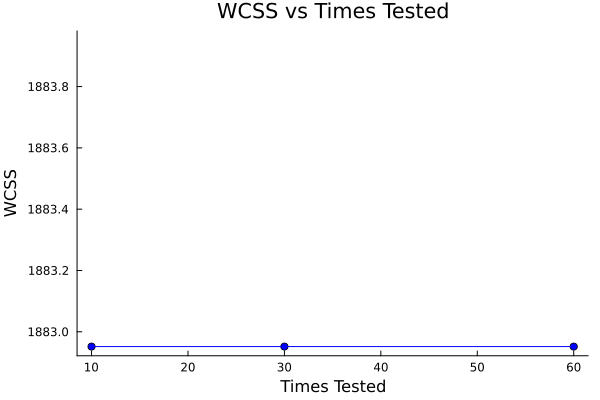

In [11]:
# evaluate_clustering(data, assignments, centers, distance)

assignments = []
centers = []
wcss = []

for i in 1:length(times_tested)
    push!(assignments, get_assignments(models[i]))
    push!(centers, get_centers(models[i]))
    push!(wcss, evaluate_clustering(data[1:num_rows,:], assignments[i], centers[i], distance))
end

scatter(times_tested, wcss, label=false, xlabel="Times Tested", ylabel="WCSS", title="WCSS vs Times Tested", grid=false, color=:blue)
plot!(times_tested, wcss, label="", line=:solid, color=:blue)

In [107]:
print(wcss_kmeans, "\n")
print(wcss, "\n")


1882.9517135860033
Any[11701.735488565871, 11701.735488565871, 10774.976767625478, 10774.976767625478, 10774.976767625478]


### Conclusion: Finds optimal after around 90

# Test 2: Large Subset of Abalone Data

In [7]:
# kmeans_optimal(data, num_rows, distance, k_max, time_limit, warm_start)

data = abalone
subset_parameter = 0.75
num_rows = floor(Int, size(abalone)[1] * subset_parameter)
distance = "manhattan"
k_max = 5
times_tested = [30, 60, 90, 120, 180]

models = []
for time_limit in times_tested
    push!(models, kmeans_optimal(data, num_rows, distance, k_max, time_limit))
end

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-20
Set parameter TimeLimit to value 30
Set parameter TimeLimit to value 30
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 285017 rows, 43893 columns and 876960 nonzeros
Model fingerprint: 0xfb719c20
Variable types: 28233 continuous, 15660 integer (15660 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]

User MIP start produced solution with objective 9586.83 (0.12s)
Loaded user MIP start with objective 9586.83

Presolve time: 0.71s
Presolved: 285017 rows, 43893 columns, 876960 nonzeros
Variable types: 28233 continuous, 15660 integer (15660 binary)

Deterministic concurrent LP optimizer: pr

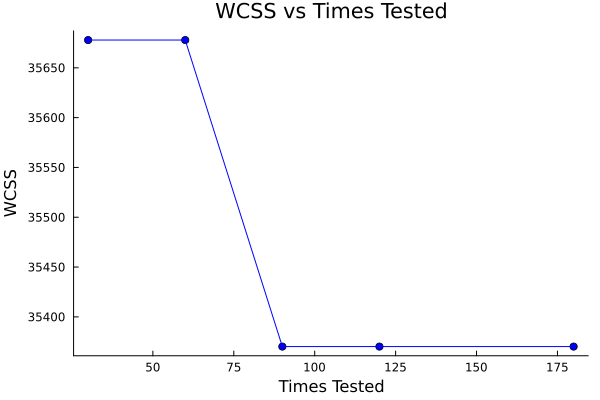

In [8]:
# evaluate_clustering(data, assignments, centers, distance)

assignments = []
centers = []
wcss = []

for i in 1:length(times_tested)
    push!(assignments, get_assignments(models[i]))
    push!(centers, get_centers(models[i]))
    push!(wcss, evaluate_clustering(data[1:num_rows,:], assignments[i], centers[i], distance))
end

scatter(times_tested, wcss, label=false, xlabel="Times Tested", ylabel="WCSS", title="WCSS vs Times Tested", grid=false, color=:blue)
plot!(times_tested, wcss, label="", line=:solid, color=:blue)

# Time vs. WCSS - Similarity_Prediction (manhattan distances)

## Test 1: Small Subset of Similarity_Prediction Data

In [39]:
# kmeans_optimal(data, num_rows, distance, k_max, time_limit, warm_start)

data = similarity_prediction
subset_parameter = 0.25
num_rows = floor(Int, size(similarity_prediction)[1] * subset_parameter)
distance = "manhattan"
k_max = 3
times_tested = [10,20,30,40,50]

models = []
for time_limit in times_tested
    push!(models, kmeans_optimal(data, num_rows, distance, k_max, time_limit))
end

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-20
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 10
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2578 rows, 551 columns and 7800 nonzeros
Model fingerprint: 0xf61a09e0
Variable types: 476 continuous, 75 integer (75 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]

User MIP start produced solution with objective 90.9306 (0.00s)
Loaded user MIP start with objective 90.9306

Presolve removed 900 rows and 168 columns
Presolve time: 0.02s
Presolved: 1678 rows, 383 columns, 5100 nonzeros
Variable types: 308 continuous, 75 integer (75 binary)

Root relaxation: objective 

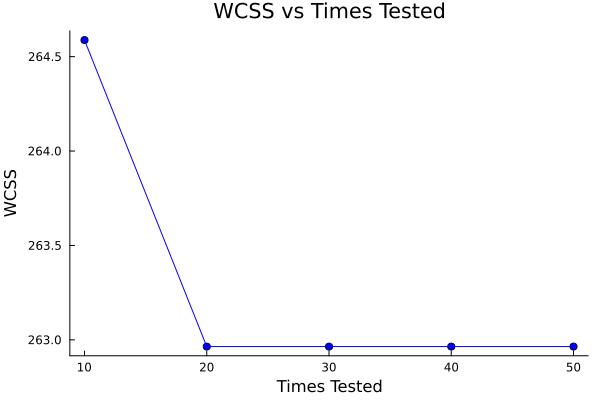

In [40]:
# evaluate_clustering(data, assignments, centers, distance)

assignments = []
centers = []
wcss = []

for i in 1:length(times_tested)
    push!(assignments, get_assignments(models[i]))
    push!(centers, get_centers(models[i]))
    push!(wcss, evaluate_clustering(data[1:num_rows,:], assignments[i], centers[i], distance))
end

scatter(times_tested, wcss, label=false, xlabel="Times Tested", ylabel="WCSS", title="WCSS vs Times Tested", grid=false, color=:blue)
plot!(times_tested, wcss, label="", line=:solid, color=:blue)

## Test 2: Large Subset of Similarity_Prediction Data

In [ ]:
# kmeans_optimal(data, num_rows, distance, k_max, time_limit, warm_start)

data = similarity_prediction
subset_parameter = 0.75
num_rows = floor(Int, size(similarity_prediction)[1] * subset_parameter)
distance = "manhattan"
k_max = 3
times_tested = [25,50,75,100,125]

models = []
for time_limit in times_tested
    push!(models, kmeans_optimal(data, num_rows, distance, k_max, time_limit))
end

In [ ]:
# evaluate_clustering(data, assignments, centers, distance)

assignments = []
centers = []
wcss = []

for i in 1:length(times_tested)
    push!(assignments, get_assignments(models[i]))
    push!(centers, get_centers(models[i]))
    push!(wcss, evaluate_clustering(data[1:num_rows,:], assignments[i], centers[i], distance))
end

scatter(times_tested, wcss, label=false, xlabel="Times Tested", ylabel="WCSS", title="WCSS vs Times Tested", grid=false, color=:blue)
plot!(times_tested, wcss, label="", line=:solid, color=:blue)

# Metric Analysis

In [51]:
using DataFrames

function run_clustering_cases(datasets, raw_data, proportions, k_values, time_limits, distances)
    results = DataFrame()
    
     for (dataset_name, data) in datasets
        for prop in proportions
            num_rows = floor(Int, size(data)[1] * prop)
            for k in k_values
                for time_limit in time_limits
                    for dist in distances
                        
                        base_result = k_means_cluster(data[1:num_rows, :], k)
                        base_assignments = base_result.assignments
                        base_centers = base_result.centers'
                        base_wcss = evaluate_clustering(data[1:num_rows, :], base_assignments, base_centers, dist)
                        base_silhouette = average_silhouette_score(data[1:num_rows, :], base_assignments, base_centers)
                        
                        base_wcss_raw = evaluate_clustering(raw_data[1:num_rows, :], base_assignments, base_centers, dist)
                        base_silhouette_raw = average_silhouette_score(raw_data[1:num_rows, :], base_assignments, base_centers)
                        # Add to results DataFrame
                        push!(results, (proportion=prop, k=k, time_limit=time_limit, distance=dist, case="Base", WCSS=base_wcss, WCSS_RAW=base_wcss_raw, Silhouette=base_silhouette, Silhouette_RAW=base_silhouette_raw))
    
                        # kmeans_optimal cases
                        for warm_start in [false, true]
                            try
                                optimal_result = kmeans_optimal(data, num_rows, dist, k, time_limit, warm_start)
                                optimal_assignments = get_assignments(optimal_result)
                                optimal_centers = get_centers(optimal_result)
                                optimal_wcss = evaluate_clustering(data[1:num_rows, :], optimal_assignments, optimal_centers, dist)
                                optimal_silhouette = average_silhouette_score(data[1:num_rows, :], optimal_assignments, optimal_centers)
    
                                optimal_wcss_raw = evaluate_clustering(raw_data[1:num_rows, :], optimal_assignments, optimal_centers, dist)
                                optimal_silhouette_raw = average_silhouette_score(raw_data[1:num_rows, :], optimal_assignments, optimal_centers)
                                
                                case_name = warm_start ? "Optimal with Warm Start" : "Optimal without Warm Start"
                                push!(results, (DatasetName=dataset_name, proportion=prop, k=k, time_limit=time_limit, distance=dist, case=case_name, WCSS=optimal_wcss, WCSS_RAW=optimal_wcss_raw, Silhouette=optimal_silhouette, Silhouette_RAW=optimal_silhouette_raw))
                            catch e
                                optimal_wcss = -15095
                                optimal_wcss_raw = -15095
                                optimal_silhouette = -15095
                                optimal_silhouette_raw = -15095
                                
                                case_name = warm_start ? "Optimal with Warm Start" : "Optimal without Warm Start"
                                push!(results, (DatasetName=dataset_name, proportion=prop, k=k, time_limit=time_limit, distance=dist, case=case_name, WCSS=optimal_wcss, WCSS_RAW=optimal_wcss_raw, Silhouette=optimal_silhouette, Silhouette_RAW=optimal_silhouette_raw))
                       
                            end
                        end
                        
                    end
                end
            end
        end
    end

    return results
end


run_clustering_cases (generic function with 2 methods)

In [37]:
df_abalone = run_clustering_cases([("normalized", abalone), 9"scaled", abalone_raw, [0.10, 0.25, 0.75], [3,4,5], [30, 90, 180], ["manhattan", "euclidean"])

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-20
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 172263 rows, 37611 columns and 526176 nonzeros
Model fingerprint: 0xd1785b94
Variable types: 28215 continuous, 9396 integer (9396 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 21118.116084
Presolve time: 0.43s
Presolved: 172263 rows, 37611 columns, 526176 nonzeros
Variable types: 28215 continuous, 9396 integer (9396 binary)

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...


Row,proportion,k,time_limit,distance,case,WCSS,Silhouette
,Float64,Int64,Int64,String,String,Float64,Float64
1,0.75,3,5,manhattan,Base,50793.7,0.511428
2,0.75,3,5,manhattan,Optimal without Warm Start,1.91391e5,0.319974
3,0.75,3,5,manhattan,Optimal with Warm Start,50793.7,0.511428
4,0.75,3,5,euclidean,Base,8439.89,0.511428
5,0.75,3,5,euclidean,Optimal without Warm Start,-15095.0,-15095.0
6,0.75,3,5,euclidean,Optimal with Warm Start,8439.89,0.511428


In [ ]:
df_similarity = run_clustering_cases([("normalized", similarity_prediction), ("scaled", similarity_prediction_scaled)],similarity_prediction_raw,
    [0.10, 0.25, 0.75], [3,4,5], [30, 90, 180], ["manhattan", "euclidean"])

In [53]:
df_abalone = run_clustering_cases([("normalized", abalone), ("scaled", abalone_scaled)], abalone_raw, [0.10], [3], [10], ["manhattan", "euclidean"])

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-20
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 10
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 22938 rows, 5031 columns and 70056 nonzeros
Model fingerprint: 0x79b3bae9
Variable types: 3780 continuous, 1251 integer (1251 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 2947.5184610
Presolve time: 0.04s
Presolved: 22938 rows, 5031 columns, 70056 nonzeros
Variable types: 3780 continuous, 1251 integer (1251 binary)

Root relaxation: objective 0.000000e+00, 1181 iterations, 0.09 seconds (0.23 work units)

    Nodes    |    Current

Row,proportion,k,time_limit,distance,case,WCSS,WCSS_RAW,Silhouette,Silhouette_RAW
,Float64,Int64,Int64,String,String,Float64,Float64,Float64,Float64
1,0.1,3,10,manhattan,Base,6950.7,1.17323e5,0.528711,0.391285
2,0.1,3,10,manhattan,Optimal without Warm Start,20036.9,1.14658e5,0.311166,0.279978
3,0.1,3,10,manhattan,Optimal with Warm Start,6945.27,1.16467e5,0.531852,0.392912
4,0.1,3,10,euclidean,Base,1062.6,55619.4,0.528711,0.391285
5,0.1,3,10,euclidean,Optimal without Warm Start,-15095.0,-15095.0,-15095.0,-15095.0
6,0.1,3,10,euclidean,Optimal with Warm Start,1062.6,55619.4,0.528711,0.391285
7,0.1,3,10,manhattan,Base,243.903,66991.8,0.714329,0.374608
8,0.1,3,10,manhattan,Optimal without Warm Start,564.4,70169.9,0.592733,0.432583
9,0.1,3,10,manhattan,Optimal with Warm Start,250.083,67449.9,0.715508,0.375991
